## Libraries

In [69]:
!pip install shap

In [70]:
pip install sklearn

  Using cached sklearn-0.0.post7.tar.gz (3.6 kB)
  Preparing metadata (setup.py) ... done
  Created wheel for sklearn: filename=sklearn-0.0.post7-py3-none-any.whl size=2952 sha256=760c4c51afa8676f9b309a9c35e380db9ae8fe6162a7eddf9075ce800939f557
  Stored in directory: /root/.cache/pip/wheels/c8/9c/85/72901eb50bc4bc6e3b2629378d172384ea3dfd19759c77fd2c
Successfully built sklearn


In [71]:
pip install optuna

In [131]:
# import libraries
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import graphviz
import xgboost as xgb
import shap
from math import sqrt
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error
from sklearn.model_selection import train_test_split, KFold

%matplotlib inline
import lightgbm as lgbm
from lightgbm import  log_evaluation, early_stopping
import optuna
from optuna.integration import LightGBMPruningCallback

from pickle import load

## Data Processing and Feature Selection

For the feature selection, I started off with dropping columns that have low correlation (< 0.4) with SalePrice. I then dropped columns with low variances (< 1). After that I checked the correlation matrix between columns to dropped selected columns that have correlation greater than 0.5 but with consideration for domain knowledge. After that I checked for NAs in the numerical columns. Then, based on the result, I used domain knowledge to fill the NAs with appropriate value. In this case, I used 0 to fill the NAs as it was the most relevant value. As for the categorical NAs, they were replaced with ‘None’. Once, all the NAs were taken cared of, I used LabelEncoder to encode the categorical values. I, then, checked for correlation between columns and dropped them based on domain knowledge.

link to the data: https://drive.google.com/drive/folders/1oml9pTxlzrMBt7qZRe2KSV8dkNkbEXvK?usp=sharing

#### Importing Data

In [73]:
dataset = pd.read_csv('train.csv')
testset = pd.read_csv('test.csv')
test_results = pd.read_csv('sample_submission.csv')

#### Examining train dataset

In [74]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [75]:
testset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1459 non-null   int64  
 1   MSSubClass     1459 non-null   int64  
 2   MSZoning       1455 non-null   object 
 3   LotFrontage    1232 non-null   float64
 4   LotArea        1459 non-null   int64  
 5   Street         1459 non-null   object 
 6   Alley          107 non-null    object 
 7   LotShape       1459 non-null   object 
 8   LandContour    1459 non-null   object 
 9   Utilities      1457 non-null   object 
 10  LotConfig      1459 non-null   object 
 11  LandSlope      1459 non-null   object 
 12  Neighborhood   1459 non-null   object 
 13  Condition1     1459 non-null   object 
 14  Condition2     1459 non-null   object 
 15  BldgType       1459 non-null   object 
 16  HouseStyle     1459 non-null   object 
 17  OverallQual    1459 non-null   int64  
 18  OverallC

#### Setting y to the label column (numpy array)

In [76]:
y = dataset['SalePrice'].values
#type(y)

In [77]:
y_test = test_results['SalePrice'].values

#### Making a new dataframe without SalePrice

In [78]:
X_start = dataset.drop(['SalePrice'], axis = 1)
X_start.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal


#### Checking for columns with low correlation (< 0.4) with SalePrice and dropping them

In [79]:
price_corr = dataset.corr()['SalePrice']

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [80]:
low_corr = price_corr[abs(price_corr) < 0.4].sort_values(ascending=False)

In [81]:
low_corr

BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePrice, dtype: float64

In [82]:
for i in low_corr.index:
    X_start.drop(i, axis = 1, inplace = True)
    testset.drop(i, axis = 1, inplace = True)

In [83]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,2,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,2,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,3,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,3,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Checking for columns with low variance (< 1) and dropping them

In [84]:
variance = X_start.var()

The default value of numeric_only in DataFrame.var is deprecated. In a future version, it will default to False. In addition, specifying 'numeric_only=None' is deprecated. Select only valid columns or specify the value of numeric_only to silence this warning.


In [85]:
low_var = variance[(variance) < 1].sort_values(ascending = True)

In [86]:
low_var

FullBath      0.303508
Fireplaces    0.415595
GarageCars    0.558480
dtype: float64

In [87]:
for i in low_var.index:
    X_start.drop(i, axis = 1, inplace = True)
    testset.drop(i, axis = 1, inplace = True)

In [88]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageFinish,GarageArea,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,548,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,RFn,460,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,RFn,608,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Unf,642,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,RFn,836,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Checking to correlation between columns and dropping selected columns based on domain knowledge

In [89]:
correlation = X_start.corr().abs()
corr_list = (correlation.where(np.triu(np.ones(correlation.shape), k=1).astype(bool))
            .stack())
high_corr = corr_list.loc[corr_list > 0.5]

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


In [90]:
high_corr

OverallQual   YearBuilt       0.572323
              YearRemodAdd    0.550684
              TotalBsmtSF     0.537808
              GrLivArea       0.593007
              GarageYrBlt     0.547766
              GarageArea      0.562022
YearBuilt     YearRemodAdd    0.592855
              GarageYrBlt     0.825667
YearRemodAdd  GarageYrBlt     0.642277
TotalBsmtSF   1stFlrSF        0.819530
1stFlrSF      GrLivArea       0.566024
GrLivArea     TotRmsAbvGrd    0.825489
GarageYrBlt   GarageArea      0.564567
dtype: float64

In [91]:
drop_hico = ['GarageArea', 'TotRmsAbvGrd', '1stFlrSF', 'GarageYrBlt', 'YearRemodAdd']

In [92]:
X_start = X_start.drop(drop_hico, axis = 1)
testset = testset.drop(drop_hico, axis = 1)

In [93]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### Identifiying numerical and categorical values for replacing NAs with appropriate values

In [94]:
numerical = X_start.select_dtypes(include=['number'])
categorical = X_start.select_dtypes(include=['object'])
t_numerical = testset.select_dtypes(include=['number'])
t_categorical = testset.select_dtypes(include=['object'])

In [95]:
numerical.head()

,OverallQual,YearBuilt,MasVnrArea,TotalBsmtSF,GrLivArea
0,7,2003,196.0,856,1710
1,6,1976,0.0,1262,1262
2,7,2001,162.0,920,1786
3,7,1915,0.0,756,1717
4,8,2000,350.0,1145,2198


In [96]:
categorical

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1456,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NWAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,MnPrv,NaN,WD,Normal
1457,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,Crawfor,Norm,...,Attchd,RFn,TA,TA,Y,NaN,GdPrv,Shed,WD,Normal
1458,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Norm,...,Attchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Normal


In [97]:
num_na = numerical.columns[numerical.isnull().any()]
num_na

Index(['MasVnrArea'], dtype='object')

#### Based on domain knowledge, NAs in MasVrArea is replaced with 0

In [98]:
for n in [num_na]:
    X_start[n] = X_start[n].fillna(0)

In [99]:
t_num_na = t_numerical.columns[t_numerical.isnull().any()]
t_num_na

Index(['MasVnrArea', 'TotalBsmtSF'], dtype='object')

In [100]:
for n in [t_num_na]:
    testset[n] = testset[n].fillna(0)

In [101]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


#### For categorical NAs, they were replaced with None

In [102]:
cat_na = categorical.columns[categorical.isnull().any()]
cat_na

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

In [103]:
for c in [cat_na]:
    X_start[c] = X_start[c].fillna('None')
    categorical[c] = categorical[c].fillna('None')

In [104]:
t_cat_na = t_categorical.columns[t_categorical.isnull().any()]
t_cat_na

Index(['MSZoning', 'Alley', 'Utilities', 'Exterior1st', 'Exterior2nd',
       'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1',
       'BsmtFinType2', 'KitchenQual', 'Functional', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature', 'SaleType'],
      dtype='object')

In [105]:
for c in [t_cat_na]:
    testset[c] = testset[c].fillna('None')
    t_categorical[c] = t_categorical[c].fillna('None')

In [106]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,None,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
1,RL,Pave,None,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
2,RL,Pave,None,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal
3,RL,Pave,None,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,None,None,None,WD,Abnorml
4,RL,Pave,None,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,None,None,None,WD,Normal


#### Checking to see if they are any NAs left

In [107]:
X_start.isnull().values.any()

False

In [108]:
testset.isnull().values.any()

False

#### Label encoding of categorical data

In [109]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

for feature in categorical.columns:
    X_start[feature]=le.fit_transform(X_start[feature])
    categorical[feature]=le.fit_transform(categorical[feature])
    testset[feature]=le.fit_transform(testset[feature])
    t_categorical[feature]=le.fit_transform(t_categorical[feature])

In [110]:
categorical.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,1,2,5,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,1,2,5,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,5,3,5,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,1,2,5,5,2,3,4,1,8,4


#### Checking for correlation between categorial columns and dropping highly correlated items based on domain knowledge

In [111]:
cat_corr = categorical.corr().abs()
cat_corr_list = (cat_corr.where(np.triu(np.ones(cat_corr.shape), k=1).astype(bool))
            .stack())
high_cat_corr = cat_corr_list.loc[cat_corr_list > 0.5]

In [112]:
high_cat_corr

Exterior1st  Exterior2nd    0.854163
ExterQual    BsmtQual       0.572327
             KitchenQual    0.641584
GarageQual   GarageCond     0.618383
dtype: float64

In [113]:
drop_hcc = ['GarageCond', 'BsmtQual', 'KitchenQual', 'Exterior2nd']

In [114]:
X_start = X_start.drop(drop_hcc, axis = 1)
testset = testset.drop(drop_hcc, axis = 1)

In [115]:
X_start.head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,FireplaceQu,GarageType,GarageFinish,GarageQual,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,3,1,1,3,3,0,4,0,5,2,...,3,1,2,5,2,3,4,1,8,4
1,3,1,1,3,3,0,2,0,24,1,...,5,1,2,5,2,3,4,1,8,4
2,3,1,1,0,3,0,4,0,5,2,...,5,1,2,5,2,3,4,1,8,4
3,3,1,1,0,3,0,0,0,6,2,...,2,5,3,5,2,3,4,1,8,0
4,3,1,1,0,3,0,2,0,15,2,...,5,1,2,5,2,3,4,1,8,4


#### Normalizing data

In [116]:
X_start = (X_start - X_start.min()) / (X_start.max() - X_start.min())
testset = (testset - testset.min()) / (testset.max() - testset.min())

In [117]:
dataset.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


#### Using Decision Tree (Random Forest) to selected the 10 best features

In [118]:
from sklearn.ensemble import RandomForestRegressor
model = RandomForestRegressor(random_state=1, max_depth=10)
model.fit(X_start,y)

RandomForestRegressor(max_depth=10, random_state=1)

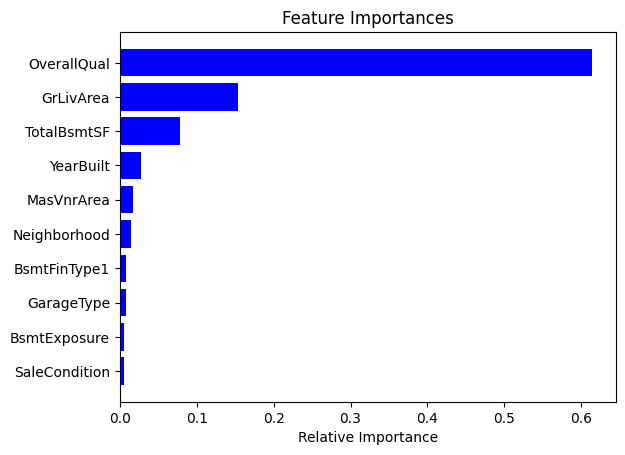

In [119]:
features = X_start.columns
importances = model.feature_importances_
indices = np.argsort(importances)[-10:]  # top 10 features
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [120]:
feat = dict(reversed(sorted(zip(model.feature_importances_, X_start.columns.values))))

In [121]:
feat10 = [feat[x] for x in list(feat)[:10]]

In [122]:
t_drop = [feat[x] for x in list(feat)[10:]]

In [123]:
for i in t_drop:
    testset.drop(i, axis = 1, inplace = True)

In [124]:
testset.shape

(1459, 10)

In [125]:
testset.head()

,Neighborhood,OverallQual,YearBuilt,MasVnrArea,BsmtExposure,BsmtFinType1,TotalBsmtSF,GrLivArea,GarageType,SaleCondition
0,0.500000,0.444444,0.625954,0.000000,0.75,0.833333,0.173111,0.104309,0.166667,0.8
1,0.500000,0.555556,0.603053,0.083721,0.75,0.000000,0.260844,0.196672,0.166667,0.8
2,0.333333,0.444444,0.900763,0.000000,0.75,0.333333,0.182139,0.260666,0.166667,0.8
3,0.333333,0.555556,0.908397,0.015504,0.75,0.333333,0.181747,0.255333,0.166667,0.8
4,0.916667,0.777778,0.862595,0.000000,0.75,0.000000,0.251227,0.186220,0.166667,0.8


In [126]:
X = X_start[feat10].copy()

In [127]:
X.head()

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,MasVnrArea,Neighborhood,BsmtFinType1,GarageType,BsmtExposure,SaleCondition
0,0.666667,0.259231,0.140098,0.949275,0.12250,0.208333,0.333333,0.166667,0.75,0.8
1,0.555556,0.174830,0.206547,0.753623,0.00000,1.000000,0.000000,0.166667,0.25,0.8
2,0.666667,0.273549,0.150573,0.934783,0.10125,0.208333,0.333333,0.166667,0.50,0.8
3,0.666667,0.260550,0.123732,0.311594,0.00000,0.250000,0.000000,0.833333,0.75,0.0
4,0.777778,0.351168,0.187398,0.927536,0.21875,0.625000,0.333333,0.166667,0.00,0.8


In [128]:
y

array([208500, 181500, 223500, ..., 266500, 142125, 147500])

#### Spiliting the training data for testing purposes

In [129]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [134]:
X_train.head()

,OverallQual,GrLivArea,TotalBsmtSF,YearBuilt,MasVnrArea,Neighborhood,BsmtFinType1,GarageType,BsmtExposure,SaleCondition
618,0.888889,0.281462,0.298200,0.978261,0.28250,0.666667,0.333333,0.166667,0.00,1.0
870,0.444444,0.105501,0.146318,0.652174,0.00000,0.500000,1.000000,0.833333,0.75,0.8
92,0.444444,0.118689,0.143372,0.355072,0.00000,0.250000,0.000000,0.833333,0.75,0.8
817,0.777778,0.255275,0.256628,0.942029,0.09250,0.458333,0.333333,0.166667,0.75,0.8
302,0.666667,0.227393,0.252209,0.934783,0.09375,0.208333,1.000000,0.166667,0.75,0.8


##Loading the picked Models

In [147]:
# load trained models
lgbm_base = load(open('lgbm_base.pkl', 'rb'))
lgbm_opt = load(open('lgbm_optimized.pkl', 'rb'))
lgbm_base_1 = load(open('lgbm_base_1.pkl', 'rb'))

##Testing the pickled Models

In [135]:
y_pred_base = lgbm_base.predict(testset)

In [136]:
y_pred_base

array([255262.38181554, 260859.24936829, 204412.97596693, ...,
       199498.24177768, 188655.7072259 , 234728.50900671])

In [142]:
y_pred_opt = lgbm_opt.predict(testset)

In [143]:
y_pred_opt

array([269827.78722226, 286761.38304113, 262921.97161172, ...,
       248499.95411655, 215731.19961257, 232258.18233653])

Testing for the Hugging Face App

In [146]:
type(testset.head(1))

pandas.core.frame.DataFrame

In [148]:
lgbm_base_1.predict(testset.head(1))

array([255262.38181554])

In [149]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

In [150]:
name_list = [
 'OverallQual',
 'YearBuilt',
 'TotalBsmtSF',
 'GrLivArea',
 'MasVnrArea',
 'BsmtFinType1',
 'Neighborhood',
 'GarageType',
 'SaleCondition',
 'BsmtExposure']

In [151]:
min_list = [
 1.0,
 1950.0,
 0.0,
 0.0,
 334.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.0
]

max_list = [
 10.0,
 2010.0,
 2336.0,
 6110.0,
 4692.0,
 7.0,
 25.0,
 7.0,
 6.0,
 5.0,
]

In [187]:
data_df = {

 'OverallQual': [max_list[0]],
 'YearBuilt': [max_list[1]],
 'TotalBsmtSF': [max_list[2]],
 'GrLivArea':[max_list[3]],
 'MasVnrArea': [max_list[4]],
 'BsmtFinType1': [max_list[5]],
 'Neighborhood': [max_list[6]],
 'GarageType': [max_list[7]],
 'SaleCondition': [max_list[8]],
 'BsmtExposure': [max_list[9]]
}

data_df = pd.DataFrame.from_dict(data_df)

In [188]:
data_df

,OverallQual,YearBuilt,TotalBsmtSF,GrLivArea,MasVnrArea,BsmtFinType1,Neighborhood,GarageType,SaleCondition,BsmtExposure
0,10.0,2010.0,2336.0,6110.0,4692.0,7.0,25.0,7.0,6.0,5.0


In [189]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 10 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1 non-null      float64
 1   YearBuilt      1 non-null      float64
 2   TotalBsmtSF    1 non-null      float64
 3   GrLivArea      1 non-null      float64
 4   MasVnrArea     1 non-null      float64
 5   BsmtFinType1   1 non-null      float64
 6   Neighborhood   1 non-null      float64
 7   GarageType     1 non-null      float64
 8   SaleCondition  1 non-null      float64
 9   BsmtExposure   1 non-null      float64
dtypes: float64(10)
memory usage: 208.0 bytes


In [190]:
d = data_df.head(1).values

Normalizing the data

In [191]:
diff = np.array(max_list)-np.array(min_list)
diff

array([9.000e+00, 6.000e+01, 2.336e+03, 6.110e+03, 4.358e+03, 6.000e+00,
       2.400e+01, 6.000e+00, 5.000e+00, 5.000e+00])

In [192]:
data_df = (data_df.values - np.array(min_list)) / diff

In [193]:
data_df

array([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]])

In [194]:
lgbm_base_1.predict(data_df)

array([489729.86565528])